In [ ]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.1/en_core_sci_sm-0.5.1.tar.gz
!pip install transformers
!pip install torchviz

In [ ]:
# Standard Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Imports from Third-party
import spacy
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
from torch.utils.data import DataLoader, TensorDataset
from transformers import AutoTokenizer, AutoModel
from tensorflow.keras.layers import Embedding, Flatten, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Local Application/Library Specific Imports
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Mtech /Dissertation/data_output/raw_data_converted_without_fp.csv')
mask = data['status'] == 'completed'
data['label'] = mask.map({True: 1, False: 0})
data= data.fillna("")
# nlp = spacy.load("en_core_sci_sm")

In [ ]:
 data['criteria_updated'][9390]

'inclusion criteria   18 59 years   newly diagnosed blast 20   central nervous system cns positive negative   signed written informed consent   graaph trial t922 bcr abl positive  exclusion criteria   lymphoblastic lymphoma   3   chronic myeloid leukemia   severe organ condition'

In [ ]:
data['combined_text'] = data['why_stop_updated'] + ' ' + data['diseases_updated'] + ' ' + data['drugs_updated'] + ' ' + data['criteria_updated']

In [ ]:
def preprocess(text):
    # Tokenize the text using spaCy
    doc = nlp(text)

    # Remove stopwords and lemmatize tokens
    tokens = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]

    # Join the tokens into a single string
    cleaned_text = " ".join(tokens)

    return cleaned_text

In [ ]:
disease_text = "Example disease text"
drug_text = "Example drug text"

# Process the text to get word embeddings
disease_doc = nlp(disease_text)
drug_doc = nlp(drug_text)

# Get word embeddings by averaging word vectors
disease_embedding = sum(token.vector for token in disease_doc) / len(disease_doc)
drug_embedding = sum(token.vector for token in drug_doc) / len(drug_doc)

print("Disease Embedding:", disease_embedding)
print("Drug Embedding:", drug_embedding)

Disease Embedding: [ 0.27357912  0.7709215   0.4077649   0.65813965  0.9709694  -0.3028069
  0.1624347   0.0265902  -0.11038357 -0.19247155 -1.1675454   1.1102308
  0.6336634  -0.44610134  0.64598507  0.09242057  0.36415863  0.9059903
 -0.8646498   0.2495954   0.7575178  -0.39942303 -0.3297925   0.71160865
 -0.19706237  0.48531076 -0.7934632  -0.96562845 -0.13780658 -1.6439234
  1.0904213  -0.32979473  1.2482778  -0.06456643 -0.9019759  -0.989682
  0.20649116 -0.8204828  -0.1891192   0.41535553 -0.1469497   0.12289172
 -0.6001037   0.05966846  0.55539715  0.8243394  -0.7385641   0.10110778
  1.3664426  -0.6907658  -0.61123675 -0.3669119  -0.9147877  -0.6021994
 -0.74936485 -1.1010908  -1.0989157  -1.0191492   0.1679322   0.0574472
  0.38851342 -0.4868772  -0.27743092  0.3129542   0.38878    -0.29073414
 -0.18687813  0.49288997  0.26999378 -0.8758974   0.17289646  1.1055303
  1.5015477  -0.54274917 -0.00206502 -0.6943858  -0.22196305  0.12097254
  0.42932543  0.08320501  0.6266942  -1.1

In [ ]:
df =data.head(1000).copy()

In [ ]:
df.columns

Index(['Unnamed: 0', 'nctid', 'status', 'why_stop', 'label', 'phase',
       'diseases', 'icdcodes', 'drugs', 'smiless', 'criteria',
       'why_stop_updated', 'diseases_updated', 'drugs_updated',
       'criteria_updated', 'combined_text'],
      dtype='object')

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = AutoModel.from_pretrained("bert-base-uncased")

def create_word_embedding(text):
    doc = nlp(text)
    return sum(token.vector for token in doc) / len(doc)

df["Disease_Embedding"] = df["diseases_updated"].apply(create_word_embedding)
df["drugs_Embedding"] = df["drugs_updated"].apply(create_word_embedding)

def create_sentence_embedding(text):
    tokens = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
    with torch.no_grad():
        embedding = model(**tokens).last_hidden_state.mean(dim=1).squeeze()
    return embedding

df["why_stopped_Embedding"] = df["why_stop_updated"].apply(create_sentence_embedding)
df["criteria_Embedding"] = df["criteria_updated"].apply(create_sentence_embedding)



In [ ]:
len(df["drugs_Embedding"][90]),len(df["Disease_Embedding"][909]),len(df["why_stopped_Embedding"][90]),len(df["criteria_Embedding"][90])

(96, 96, 768, 768)

In [ ]:
# Assuming you have columns "sentence_embedding_1," "sentence_embedding_2," "word_embedding_1," and "word_embedding_2"
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(df, test_size=0.1, random_state=42)

sentence_embedding_1_numpy = train_df["why_stopped_Embedding"].apply(np.array).values
sentence_embedding_2_numpy = train_df["criteria_Embedding"].apply(np.array).values

# Convert NumPy arrays to PyTorch tensors
X_train_sentence_1 = torch.stack([torch.Tensor(embedding) for embedding in sentence_embedding_1_numpy])
X_train_sentence_2 = torch.stack([torch.Tensor(embedding) for embedding in sentence_embedding_2_numpy])

# Similarly, convert validation data
val_sentence_embedding_1_numpy = val_df["why_stopped_Embedding"].apply(np.array).values
val_sentence_embedding_2_numpy = val_df["criteria_Embedding"].apply(np.array).values

X_val_sentence_1 = torch.stack([torch.Tensor(embedding) for embedding in val_sentence_embedding_1_numpy])
X_val_sentence_2 = torch.stack([torch.Tensor(embedding) for embedding in val_sentence_embedding_2_numpy])


X_train_word_1 = torch.stack([torch.Tensor(arr) for arr in train_df["drugs_Embedding"].values])
X_train_word_2 = torch.stack([torch.Tensor(arr) for arr in train_df["Disease_Embedding"].values])
X_val_word_1 = torch.stack([torch.Tensor(arr) for arr in val_df["drugs_Embedding"].values])
X_val_word_2 = torch.stack([torch.Tensor(arr) for arr in val_df["Disease_Embedding"].values])


y_train = torch.tensor(train_df["label"].values)
y_val = torch.tensor(val_df["label"].values)


In [ ]:
from torch.utils.data import DataLoader, TensorDataset

# Assuming you have X_train_word_1, X_train_word_2, X_train_sentence_1, and X_train_sentence_2
# These tensors should have the same number of samples (batch_size)

# Concatenate the embeddings for each data point
concatenated_embeddings = []
for i in range(len(X_train_word_1)):
    concatenated = torch.cat([X_train_word_1[i], X_train_word_2[i], X_train_sentence_1[i], X_train_sentence_2[i]], dim=0)
    concatenated_embeddings.append(concatenated)

# Convert the list of concatenated embeddings to a tensor
X_train_concatenated = torch.stack(concatenated_embeddings)

# Assuming you also have y_train as your labels
train_dataset = TensorDataset(X_train_concatenated, y_train)
batch_size = 32  # Choose an appropriate batch size
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
concatenated_embeddings = []
for i in range(len(X_val_word_1)):
    concatenated = torch.cat([X_val_word_1[i], X_val_word_2[i], X_val_sentence_1[i], X_val_sentence_2[i]], dim=0)
    concatenated_embeddings.append(concatenated)

# Convert the list of concatenated embeddings to a tensor
X_val_concatenated = torch.stack(concatenated_embeddings)

# Assuming you also have y_train as your labels
val_dataset = TensorDataset(X_val_concatenated, y_val)
batch_size = 32  # Choose an appropriate batch size
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
X_train_concatenated.shape[1], X_val_concatenated.shape[1]

(1728, 1728)

In [ ]:
import torch
import torch.nn as nn

class SingleInputModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(SingleInputModel, self).__init__()

        # Define layers for combined embeddings
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.output_fc = nn.Linear(hidden_size, num_classes)

    def forward(self, combined_embedding):
        # Pass through layers
        x = torch.relu(self.fc1(combined_embedding))
        x = torch.relu(self.fc2(x))

        # Output layer (single value for binary classification)
        output = torch.sigmoid(self.output_fc(x))  # Sigmoid activation for binary classification

        return output

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Define your input parameters
input_size = X_train_concatenated.shape[1]  # Assuming you have concatenated embeddings of size 864
hidden_size = 128  # Adjust as needed
num_classes = 1  # Binary classification, so output size is 1
batch_size = 32
learning_rate = 0.001
num_epochs = 10

# Define your model
model = SingleInputModel(input_size, hidden_size, num_classes)

# Define your loss function (binary cross-entropy for binary classification)
criterion = nn.BCELoss()

# Define your optimizer (Adam is a common choice)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_model1 = []
# Assuming you have a DataLoader for training data named train_loader
# Make sure your labels (y_train) are formatted as FloatTensors
# Convert them to FloatTensors if needed: y_train = torch.FloatTensor(y_train)

# Training loop
for epoch in range(num_epochs):
    model.train()  # Set the model in training mode
    total_loss = 0.0

    for inputs, labels in train_loader:
        # Forward pass
        outputs = model(inputs)

        labels = labels.float()
        # Calculate the loss
        loss = criterion(outputs, labels.view(-1, 1))  # Reshape labels if needed

        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # Calculate average loss for the epoch
    average_loss = total_loss / len(train_loader)
    loss_model1.append(average_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}] | Loss: {average_loss:.4f}")

print("Training finished.")

Epoch [1/10] | Loss: 0.3322
Epoch [2/10] | Loss: 0.2565
Epoch [3/10] | Loss: 0.2524
Epoch [4/10] | Loss: 0.2557
Epoch [5/10] | Loss: 0.2389
Epoch [6/10] | Loss: 0.2256
Epoch [7/10] | Loss: 0.2894
Epoch [8/10] | Loss: 0.2239
Epoch [9/10] | Loss: 0.2416
Epoch [10/10] | Loss: 0.2233
Training finished.


In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

model.eval()  # Set the model in evaluation mode

true_labels = []
predicted_labels = []
predicted_labels_model1 = []
with torch.no_grad():  # Disable gradient computation for evaluation
    for inputs, labels in val_loader:
        # Forward pass
        outputs = model(inputs)

        # Convert labels to FloatTensor if needed
        labels = labels.float()  # Convert to FloatTensor

        # Threshold outputs to get binary predictions (0 or 1)
        predictions = (outputs >= 0.5).float()

        # Append true labels and predicted labels
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predictions.cpu().numpy())
        predicted_labels_model1.extend(predictions.cpu().numpy())
# Compute the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Compute classification metrics
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)

print("Confusion Matrix:")
print(conf_matrix)
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")


Confusion Matrix:
[[26  8]
 [ 0 66]]
Accuracy: 0.9200
Precision: 0.8919
Recall: 1.0000
F1-Score: 0.9429


In [ ]:
import torch
import torch.nn as nn

class EnhancedModel(nn.Module):
    def __init__(self, input_size, hidden_sizes, num_classes):
        super(EnhancedModel, self).__init__()

        # Define layers for combined embeddings
        self.fc_layers = nn.ModuleList()

        # Input layer
        self.fc_layers.append(nn.Linear(input_size, hidden_sizes[0]))

        # Hidden layers
        for i in range(1, len(hidden_sizes)):
            self.fc_layers.append(nn.Linear(hidden_sizes[i-1], hidden_sizes[i]))

        # Output layer
        self.output_fc = nn.Linear(hidden_sizes[-1], num_classes)

    def forward(self, combined_embedding):
        # Pass through fully connected layers
        for fc_layer in self.fc_layers:
            combined_embedding = torch.relu(fc_layer(combined_embedding))

        # Output layer (single value for binary classification)
        output = torch.sigmoid(self.output_fc(combined_embedding))  # Sigmoid activation for binary classification

        return output

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Define your input parameters
input_size = X_train_concatenated.shape[1]  # Assuming you have concatenated embeddings of size 864
hidden_size = [512, 256, 128, 64] # Adjust as needed
num_classes = 1  # Binary classification, so output size is 1
batch_size = 32
learning_rate = 0.001
num_epochs = 10

# Define your model
model = EnhancedModel(input_size, hidden_size, num_classes)

# Define your loss function (binary cross-entropy for binary classification)
criterion = nn.BCELoss()

# Define your optimizer (Adam is a common choice)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Assuming you have a DataLoader for training data named train_loader
# Make sure your labels (y_train) are formatted as FloatTensors
# Convert them to FloatTensors if needed: y_train = torch.FloatTensor(y_train)
loss_model2 = []
# Training loop
for epoch in range(num_epochs):
    model.train()  # Set the model in training mode
    total_loss = 0.0

    for inputs, labels in train_loader:
        # Forward pass
        outputs = model(inputs)

        labels = labels.float()
        # Calculate the loss
        loss = criterion(outputs, labels.view(-1, 1))  # Reshape labels if needed

        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # Calculate average loss for the epoch
    average_loss = total_loss / len(train_loader)
    loss_model2.append(average_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}] | Loss: {average_loss:.4f}")

print("Training finished.")

Epoch [1/10] | Loss: 0.4155
Epoch [2/10] | Loss: 0.2730
Epoch [3/10] | Loss: 0.2443
Epoch [4/10] | Loss: 0.2569
Epoch [5/10] | Loss: 0.2250
Epoch [6/10] | Loss: 0.2231
Epoch [7/10] | Loss: 0.2184
Epoch [8/10] | Loss: 0.2005
Epoch [9/10] | Loss: 0.1985
Epoch [10/10] | Loss: 0.2011
Training finished.


Confusion Matrix:
[[26  8]
 [ 0 66]]
Accuracy: 0.9200
Precision: 0.8919
Recall: 1.0000
F1-Score: 0.9429


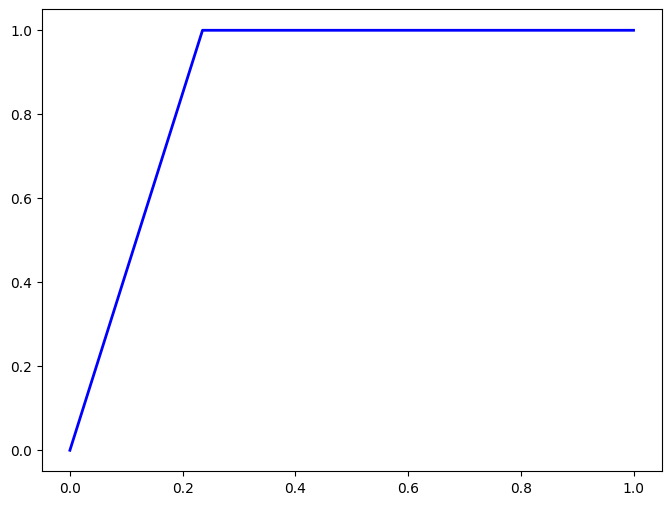

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

model.eval()  # Set the model in evaluation mode

true_labels = []
predicted_labels = []
predicted_labels_model2 = []
with torch.no_grad():  # Disable gradient computation for evaluation
    for inputs, labels in val_loader:
        # Forward pass
        outputs = model(inputs)

        # Convert labels to FloatTensor if needed
        labels = labels.float()  # Convert to FloatTensor

        # Threshold outputs to get binary predictions (0 or 1)
        predictions = (outputs >= 0.5).float()

        # Append true labels and predicted labels
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predictions.cpu().numpy())
        predicted_labels_model2.extend(predictions.cpu().numpy())
# Compute the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Compute classification metrics
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)

print("Confusion Matrix:")
print(conf_matrix)
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
fpr_model1, tpr_model1, _ = roc_curve(true_labels, predicted_labels)
roc_auc_model1 = auc(fpr_model1, tpr_model1)
plt.figure(figsize=(8, 6))
plt.plot(fpr_model1, tpr_model1, color='blue', lw=2, label=f'SingleInputModel (AUC = {roc_auc_model1:.2f})')
plt.show()

In [ ]:
Confusion Matrix:
[[30  4]
 [20 46]]
Accuracy: 0.7600
Precision: 0.9200
Recall: 0.6970
F1-Score: 0.7931

In [ ]:
Confusion Matrix:
[[26  8]
 [ 1 65]]
Accuracy: 0.9100
Precision: 0.8904
Recall: 0.9848
F1-Score: 0.9353

In [ ]:
import torch
import torch.nn as nn

class EnhancedModel_hyper(nn.Module):
    def __init__(self, input_size, hidden_sizes, num_classes, dropout_prob=0.5):
        super(EnhancedModel_hyper, self).__init__()

        # Define layers for combined embeddings
        self.fc_layers = nn.ModuleList()

        # Input layer
        self.fc_layers.append(nn.Linear(input_size, hidden_sizes[0]))

        # Hidden layers
        for i in range(1, len(hidden_sizes)):
            self.fc_layers.append(nn.Linear(hidden_sizes[i-1], hidden_sizes[i]))
            self.fc_layers.append(nn.Dropout(dropout_prob))
        # Output layer
        self.output_fc = nn.Linear(hidden_sizes[-1], num_classes)

    def forward(self, combined_embedding):
        # Pass through fully connected layers
        for fc_layer in self.fc_layers:
            combined_embedding = torch.relu(fc_layer(combined_embedding))

        # Output layer (single value for binary classification)
        output = torch.sigmoid(self.output_fc(combined_embedding))  # Sigmoid activation for binary classification

        return output

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Define your input parameters
input_size = X_train_concatenated.shape[1]  # Assuming you have concatenated embeddings of size 864
hidden_size = [512, 256, 128, 64] # Adjust as needed
num_classes = 1  # Binary classification, so output size is 1
batch_size = 16
learning_rate = 0.001
num_epochs = 10

# Define your model
model = EnhancedModel_hyper(input_size, hidden_size, num_classes)

# Define your loss function (binary cross-entropy for binary classification)
criterion = nn.BCELoss()

# Define your optimizer (Adam is a common choice)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)

# Assuming you have a DataLoader for training data named train_loader
# Make sure your labels (y_train) are formatted as FloatTensors
# Convert them to FloatTensors if needed: y_train = torch.FloatTensor(y_train)
loss_model3= []
# Training loop
for epoch in range(num_epochs):
    model.train()  # Set the model in training mode
    total_loss = 0.0

    for inputs, labels in train_loader:
        # Forward pass
        outputs = model(inputs)

        labels = labels.float()
        # Calculate the loss
        loss = criterion(outputs, labels.view(-1, 1))  # Reshape labels if needed

        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # Calculate average loss for the epoch
    average_loss = total_loss / len(train_loader)
    loss_model3.append(average_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}] | Loss: {average_loss:.4f}")

print("Training finished.")

Epoch [1/10] | Loss: 0.4702
Epoch [2/10] | Loss: 0.2855
Epoch [3/10] | Loss: 0.2652
Epoch [4/10] | Loss: 0.2803
Epoch [5/10] | Loss: 0.2591
Epoch [6/10] | Loss: 0.2577
Epoch [7/10] | Loss: 0.2534
Epoch [8/10] | Loss: 0.2485
Epoch [9/10] | Loss: 0.2392
Epoch [10/10] | Loss: 0.2160
Training finished.


In [ ]:
from sklearn import metrics

Confusion Matrix:
[[26  8]
 [ 0 66]]
Accuracy: 0.9200
Precision: 0.8919
Recall: 1.0000
F1-Score: 0.9429


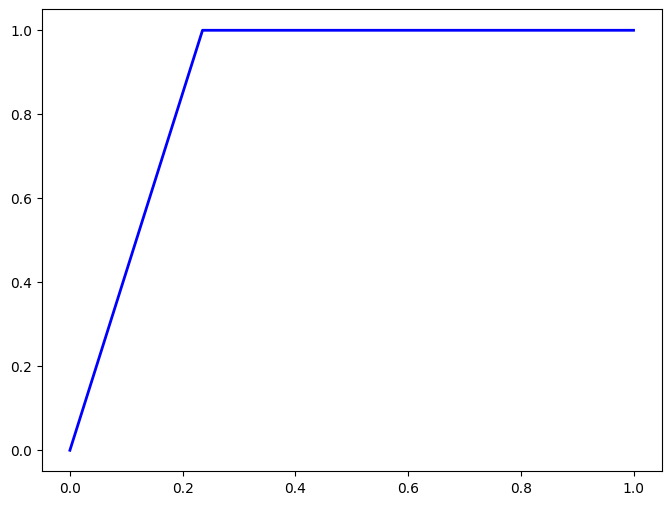

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

model.eval()  # Set the model in evaluation mode

true_labels = []
predicted_labels = []
predicted_labels_model3= []
with torch.no_grad():  # Disable gradient computation for evaluation
    for inputs, labels in val_loader:
        # Forward pass
        outputs = model(inputs)

        # Convert labels to FloatTensor if needed
        labels = labels.float()  # Convert to FloatTensor

        # Threshold outputs to get binary predictions (0 or 1)
        predictions = (outputs >= 0.6).float()

        # Append true labels and predicted labels
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predictions.cpu().numpy())
        predicted_labels_model3.extend(predictions.cpu().numpy())
# Compute the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Compute classification metrics
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)

print("Confusion Matrix:")
print(conf_matrix)
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
fpr_model1, tpr_model1, _ = roc_curve(true_labels, predicted_labels)
roc_auc_model1 = auc(fpr_model1, tpr_model1)
plt.figure(figsize=(8, 6))
plt.plot(fpr_model1, tpr_model1, color='blue', lw=2, label=f'SingleInputModel (AUC = {roc_auc_model1:.2f})')
plt.show()

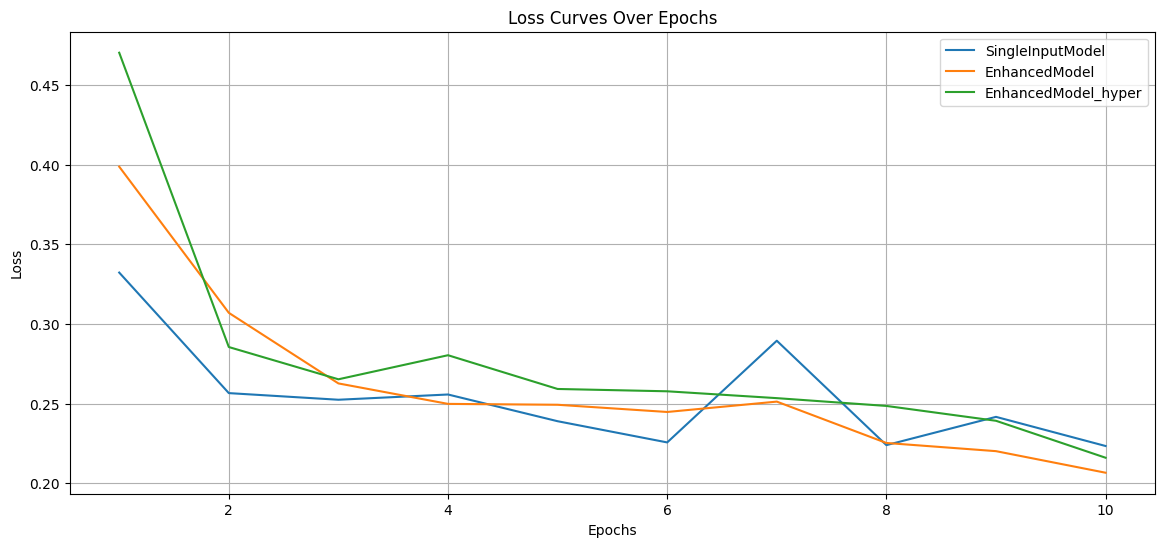

In [ ]:
import matplotlib.pyplot as plt

# # Loss values for each model
# loss_model1 = [0.3790, 0.2816, 0.2515, 0.2237, 0.2207, 0.2405, 0.2152, 0.2169, 0.2304, 0.2454]
# loss_model2 = [0.3842, 0.3121, 0.2827, 0.2438, 0.2301, 0.2212, 0.2237, 0.2077, 0.2245, 0.2011]
# loss_model3 = [0.5019, 0.3251, 0.2579, 0.2562, 0.2562, 0.2552, 0.2267, 0.2410, 0.2220, 0.2520]

# Epochs (assuming 10 epochs in this example)
epochs = range(1, 11)

# Create a line plot for loss values
plt.figure(figsize=(14, 6))
plt.plot(epochs, loss_model1, label='SingleInputModel')
plt.plot(epochs, loss_model2, label='EnhancedModel')
plt.plot(epochs, loss_model3, label='EnhancedModel_hyper')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curves Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

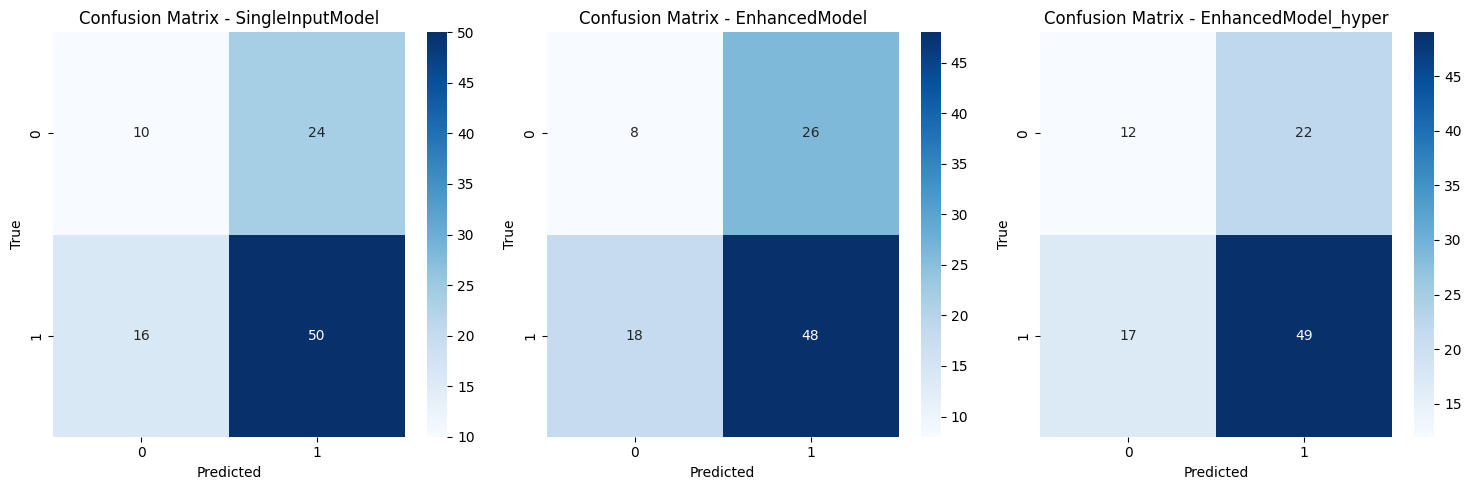

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# True labels and predicted labels for each model
true_labels_model1 = np.array(y_val)
predicted_labels_model1= np.array(predicted_labels_model1) #= np.array([0, 1, 1, 1, 0, 0, 0, 1])

true_labels_model2 = np.array(y_val)
predicted_labels_model2 = np.array(predicted_labels_model2)#= np.array([0, 1, 0, 1, 0, 1, 1, 1])

true_labels_model3 = np.array(y_val)
predicted_labels_model3 = np.array(predicted_labels_model3) # = np.array([0, 1, 1, 1, 0, 1, 0, 1])

# List of model names
model_names = ['SingleInputModel', 'EnhancedModel', 'EnhancedModel_hyper']

# Create a grid of subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Loop through models and plot confusion matrices
for i, model_name in enumerate(model_names):
    ax = axes[i]
    true_labels = eval(f'true_labels_model{i + 1}')
    predicted_labels = eval(f'predicted_labels_model{i + 1}')
    cm = confusion_matrix(true_labels, predicted_labels)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax)
    ax.set_title(f'Confusion Matrix - {model_name}')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')

plt.tight_layout()
plt.show()

In [ ]:
np.array(predicted_labels_model1)

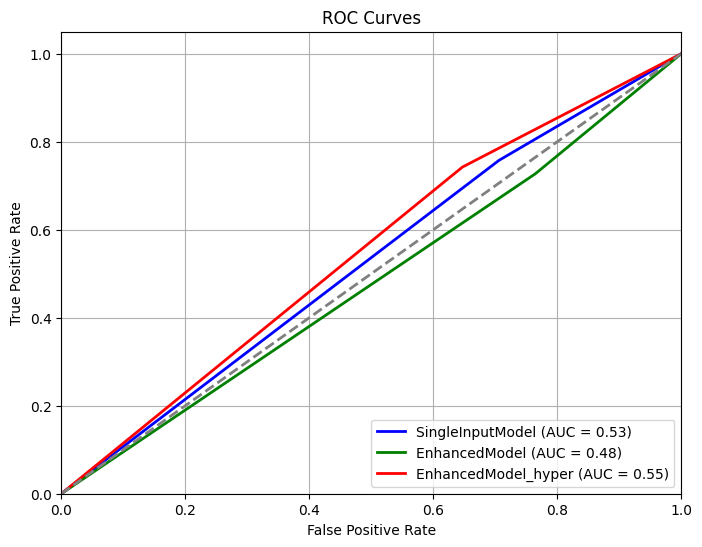

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, auc

# Calculate ROC curve and AUC for each model
fpr_model1, tpr_model1, _ = roc_curve(true_labels, predicted_labels_model1)
roc_auc_model1 = auc(fpr_model1, tpr_model1)

fpr_model2, tpr_model2, _ = roc_curve(true_labels, predicted_labels_model2)
roc_auc_model2 = auc(fpr_model2, tpr_model2)

fpr_model3, tpr_model3, _ = roc_curve(true_labels, predicted_labels_model3)
roc_auc_model3 = auc(fpr_model3, tpr_model3)

# Create ROC curves
#['SingleInputModel', 'EnhancedModel', 'EnhancedModel_hyper']
plt.figure(figsize=(8, 6))
plt.plot(fpr_model1, tpr_model1, color='blue', lw=2, label=f'SingleInputModel (AUC = {roc_auc_model1:.2f})')
plt.plot(fpr_model2, tpr_model2, color='green', lw=2, label=f'EnhancedModel (AUC = {roc_auc_model2:.2f})')
plt.plot(fpr_model3, tpr_model3, color='red', lw=2, label=f'EnhancedModel_hyper (AUC = {roc_auc_model3:.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


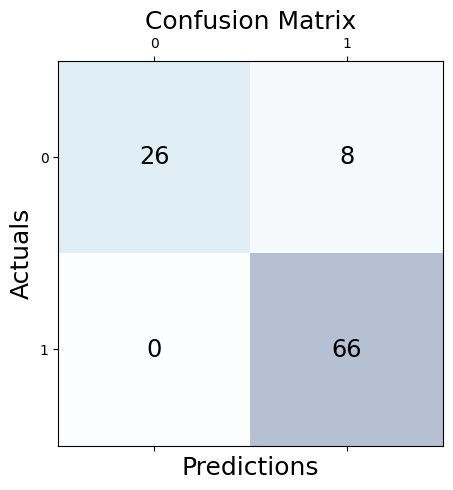

In [ ]:

from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
#
# Get the predictions
#
# y_pred = pipeline.predict(X_test)
#
# Calculate the confusion matrix
#Confusion Matrix:
# [[30  4]
#  [20 46]]
# Accuracy: 0.7600
# Precision: 0.9200
# Recall: 0.6970
# F1-Score: 0.7931[[26  8]  [ 1 65]]
#[[26  8]
# [ 0 66]]
import numpy as np

data = np.array([[26, 8], [0, 66]])
# print(data)

conf_matrix = confusion_matrix
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow([[26, 8], [0, 66]], cmap=plt.cm.Blues, alpha=0.3)
for i in range(2):
    for j in range(2):
        ax.text(x=j, y=i,s=data[i, j], va='center', ha='center', size='xx-large')

plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [ ]:
from torchviz import make_dot
input_size = X_train_concatenated.shape[1]
model = EnhancedModel_hyper(input_size, [512, 256, 128, 64], 1)
x = torch.randn(1, input_size)  # Create a dummy input tensor
out = model(x)
dot = make_dot(out)
dot.render("model", format="png")  # Save the visualization as a PNG file